# Cubic Interpolating B-Spline Interpolation

Safe primes are quite important to cryptography, as they are unusually difficult to factor. They come in the form $p = 2q + 1$, where $q$ is also prime. Unfortunately, we usually require a very large random safe prime, and in a classroom setting we often ask students to generate these primes as-needed.

You might consider this algorithm for finding a safe prime:

1. Pick a number for $q$ from a cryptographically-secure pseudo-random number generator (CSPRNG) that's in the proper size range.
2. Check if it is prime; if not, go to step 1.
3. Calculate $p = 2q + 1$, and test if $p$ is also prime.
4. If not, go to step 1; otherwise terminate.

One big problem with it is that CSPRNGs involve a non-trivial number of calculations. This algorithm only invokes it once, yet still is cryptographically secure:

1. Pick a number for $q$ from a CSPRNG that's in the proper size range, *and happens to be odd*.
2. Check if it is prime; if not; *add two and retry step 2*.
3. Calculate $p = 2q + 1$, and test if $p$ is also prime.
4. If not, *add 2 to $q$ and go to step 2*; otherwise terminate.

We already know there's only one prime divisible by two, and it's almost certainly too small to be a useful answer for $q$. Note that this doesn't just save time by being stingy with the CSPRNG, it also doesn't bother doing prime tests on numbers we already know cannot be prime. On paper, that alone leads to a 2x speed-up.

Can we do better? Certainly:

1. Pick a number for $q$ from a CSPRNG that's in the proper size range *and $q \equiv 5 \mod 6$*.
2. Check if it is prime; if not; *add six and retry step 2*.
3. Calculate $p = 2q + 1$, and test if $p$ is also prime.
4. If not, *add 6 to $q$ and go to step 2*; otherwise terminate.

Now we're six times faster (in theory), yet still using cryptographically-secure random numbers. How does this work?  Consider the following algorithm:

1. Pick a number for $q$ from a CSPRNG that's in the proper size range.
2. For each prime $p_i \in \{2, 3, 5, 7, \dots\}$, test if $q \equiv 0 \mod p_i$ and $2q + 1 \equiv 0 \mod p_i$
3. If it is, go to step 1; otherwise, terminate.

The good news is that if this algorithm terminates, we know the value isn't prime. The bad news is that never terminates when considering a safe prime, because there are infinitely many primes. But what if we used a finite subset of primes as a pre-filter to our main primality test? If that test is slow, the result could still be significantly faster. 

The obvious way to implement this is:

1. Pick a number for $q$ from a CSPRNG that's in the proper size range and $q \equiv 5 \mod 6$.
2. For each prime $p_i \in \{2, 3, 5, 7, \dots\, p_n\}$, test if $q \equiv 0 \mod p_i$ and $2q + 1 \equiv 0 \mod p_i$
3. If it is, add 6 to $q$ and go to step 2.
4. Check if $q$ is prime; if not, add 6 and go to step 2.
5. Check if $p = 2q + 1$ is prime; if not, add 6 to $q$ and go to step 2.

But there's two problems with it. First, how many primes should we use in our pre-filter? Second, there's a lot of modular arithmetic involved, and that's one of the slowest basic operations you can do on a computer. We can fix the latter problem by memorizing which modulo residues could plausibly be prime and only checking those. 

In fact, we've already taken advantage of this trick twice. If we're to use just one prime, 2 would be ideal since half of all natural numbers are divisible by it. The only modulo residue of 2 which could lead to a prime is 1, so we only need to test $q \equiv 1 \mod 2$, in other words only the odd numbers. If we want to use two primes, 2 and 3 are the ideal choices. Using $2 \times 3 = 6$ as our modulo guarantees we're properly accounting for every multiple of 2 and 3. Grind through the possibilities, and only $q \equiv 5 \mod 6$ is what remains.

Unfortunately, the results get messy as we extend this trick. For $2 \times 3 \times 5 = 30$, $q$ could be 5, 11, 23, or 29 mod 30. That's still an improvement over $q \equiv 5 \mod 6$, but the code to do that begins to get messy.  With some experimentation I settled on using five primes in the sieve; larger look-up tables led to cache misses, which are more expensive than modulo operations.

You can see the results of my experiments in the charts below. Linear scanning saves a significant amount of time, but the $q \equiv 5 \mod 6$ algorithm doesn't save as much time as we'd figured. The five prime sieve nonetheless manages to be faster than all those. In another surprise, all of those pale in comparison to using modulo arithmetic, which is something like 5x faster despite using slower operations and a larger look-up table. How much faster is very hard to tell, though: the performance curve follows a "V" based on the number of primes used, but the bottom and far side of that curve is very shallow and hidden by noise. Worse, the first chart suggests the five prime sieve should be faster than $q \equiv 5 \mod 6$, but there's so much noise in the second we can't state that conclusively.

There's two ways to clear through that noise. We could use what we know about prime testing to come up with a model of execution, or we could give up on that and smooth out the curve by using B-splines. The latter approach states that this algorithm's run time is the output of a spline curve plus a noise component. What values are being interpolated? Leave that up to the sampling algorithm to figure out, by making them parameters. You could supply knot locations via your Python template, or also make them parameters and let the sampler figure it out. For bonus points, don't use a Gaussian distribution to model noise, but a gamma distribution instead.

We have an arbitrary number of B-splines to choose from. Piecewise, linear, quadratic, cubic, or any polynomial degree higher are all fair game. For degrees of two or higher, we can also pick between natural and interpolating splines. The former lead to the smoother "well-behaved" curves, while the latter guarantee that the interpolated curve will pass through certain points. We can also choose from an arbitrary number of basis polynomials, as well. 

This notebook uses a reimplementation of Numeric Recipe's interpolating cubic B-spline, [developed by Haysn Hornbeck](https://arxiv.org/abs/2001.09253). The acceleration of a cubic B-spline is the lowest degree where the acceleration at any point along the curve is at least linearlly interpolated, which is a decent approximation of how that behaves in real life. Somewhat surprisingly, this algorithm is often slower than Milad Kharratzadeh's despite this one being $O(k)$ on the number of knots, because the inner loop involves non-trivial calculations to determine the second derivates at each point. Nonetheless, the interpolating nature of this B-spline, combined with the ability to control the derivates (and if you wish, the locations as well) at either end, make it a very attractive alternative.

# Imports

In [2]:
import arviz as az
from cmdstanpy import install_cmdstan, CmdStanModel

import matplotlib.pyplot as plt
import numpy as np
from os import mkdir
from os.path import exists, isdir

import pandas as pd
import scipy as sp
from tqdm import tqdm as tqdm

In [3]:
# This can take a few minutes, so consider running it now then tabbing back
install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /home/hjhornbeck/.cmdstan
CmdStan version 2.32.2 already installed


True

# Global Variables / Methods

In [4]:
data_file  = 'data/safe_prime_algorithms.csv.bz2'
model_file = 'models/splines.natural.stan'

# create some useful directories
for directory in ['data','derived','models','posteriors']:
    if not isdir(directory):
        mkdir(directory)

rng = np.random.default_rng(42)

# Data

In [8]:
# if it hasn't been cached, download it!
if not exists( data_file ):
    
    cleaned = pd.read_csv( 'https://gitlab.com/hjhornbeck/probabilistic-programming-2023/' + \
                          '-/raw/master/data/safe_prime_algorithms.csv.bz2' )
    cleaned.to_csv( data_file, index=False )

cleaned = pd.read_csv( data_file )

In [9]:
pd.Categorical( cleaned.algorithm ).categories

Index(['5 mod 6', '5 mod 6 with mod test', '5 mod 6 with mod test, improved',
       '5-sieve', '5-sieve with mod test', 'linear', 'random'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


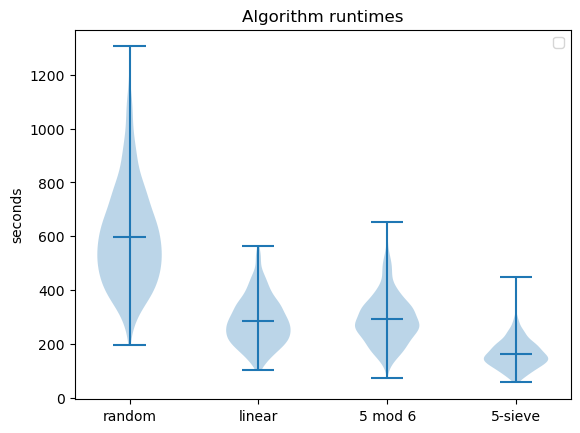

In [30]:
storage = {cat: cleaned[cleaned.algorithm == cat]['avg. time'] \
           for i,cat in enumerate(['random','linear','5 mod 6','5-sieve'])}
plt.violinplot( storage.values(), range(len(storage)), showmeans=True )
plt.title("Algorithm runtimes")
plt.xticks(range(len(storage)), list(storage.keys())); plt.ylabel('seconds')
plt.show()

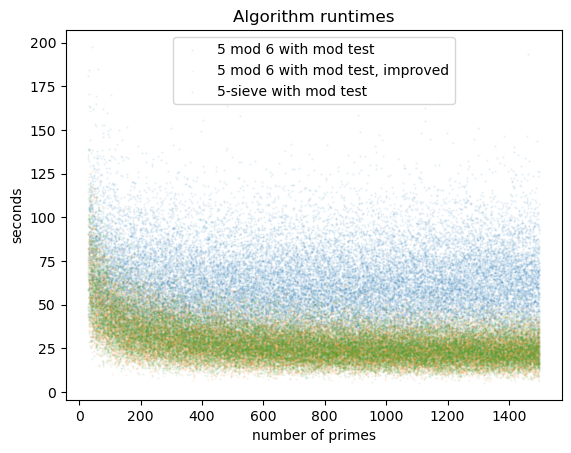

In [29]:
for i,cat in enumerate(['5 mod 6 with mod test', '5 mod 6 with mod test, improved', '5-sieve with mod test']):
    mask = cleaned.algorithm == cat
    plt.scatter( cleaned[mask].parameter, cleaned[mask]['avg. time'], s=.3, label=cat, alpha=.1 )
    
plt.title("Algorithm runtimes"); plt.xlabel('number of primes'); plt.ylabel('seconds')
plt.legend(); plt.show()

# Model

In [6]:
stan_code = '''
functions {

  // Fast Cubic Spline interpolator
  // https://arxiv.org/abs/2001.09253
  real newint( 
        real x,  /* a value between a and b */
        real a,  /* the lower knot we are interpolating between */
        real b,  /* the upper knot. Note: b MUST be greater than a */
        real u,  /* the value corresponding to the lower knot */
        real v,  /* the value for the upper knot */
        real up, /* the second derivative at the lower knot */
        real vp  /* the second derivative at the upper */
        ) {
    
    real ba         = b - a;
    real xa         = x - a;
    real inv_ba     = 1. / ba;
    real bx         = b - x;
    real ba2        = ba * ba;
    
    real low        = xa*v + bx*u;
    real C          = (xa*xa - ba2)*xa*vp;
    real D          = (bx*bx - ba2)*bx*up;
    
    return ( low + ( C + D )/6 ) * inv_ba;
    }

  // interpolate, with the help of the prior function
  vector interpolate( 
        vector X,       /* the knots to target, sorted in ascending order */
        vector knots,   /* the source knots, sorted in ascending order */
        vector values,  /* the corresponding values for the above source knots */
        vector secder   /* the corresponding second derivatives for the above source knots */
        ) {

        int M = size(X);        // create the return
        vector[M] retVal;
        int N = size(knots);

        int right = 2;          // right-most knot index
        for( j in 1:M ) {
                                // move to the right, if necessary
                while( (knots[right] < X[j]) && (right < N)  ) { right += 1; }

                retVal[j] = newint( X[j], knots[right-1], knots[right], 
                        values[right-1], values[right],
                        secder[right-1], secder[right] );
                }

        return retVal;

    }

  // Second-derivative generator
  // https://arxiv.org/abs/2001.09253
  vector new_second_derivative( 
                vector knots,     /* the knots we're calculating second derivatives for */
                vector values,    /* the values associated with the above */
                real start_deriv, /* the first derivative at the start of the spline */
                real end_deriv    /* the last derivative. Values > 1e31 imply natural splines */
                ) {

    int n  = size(knots);

    vector[n] c_p;
    vector[n] ypp;

    // recycle these values in later routines
    real new_x        = knots[2];
    real new_y        = values[2];
    real cj           = knots[2] - knots[1];
    real new_dj       = (values[2] - values[1]) / cj;
    
    // initialize the forward substitution
    if ( start_deriv > .99e30 ) {

        c_p[1] = 0.;
        ypp[1] = 0.;
        }
     else {

        c_p[1] = 0.5;
        ypp[1] = 3. * (new_dj - start_deriv) / cj;
        }
     
    // forward substitution portion
    int j = 2;
    while ( j < n ) {
        
        // shuffle new values to old
        real old_x    = new_x;
        real old_y    = new_y;
        
        real aj       = cj;
        real old_dj   = new_dj;
        
        // generate new quantities
        new_x = knots[j+1];
        new_y = values[j+1];
        
        cj             = new_x - old_x;
        new_dj         = (new_y - old_y) / cj;
        real bj        = 2.*(cj + aj);
        real inv_denom = 1. / (bj - aj*c_p[j-1]);
        real dj        = 6.*(new_dj - old_dj);
        
        ypp[j] = (dj - aj*ypp[j-1]) * inv_denom;
        c_p[j] = cj * inv_denom;
        j += 1;
        
        }
    // handle the end derivative
    if ( end_deriv > .99e30 ) {

        c_p[n] = 0.;
        ypp[n] = 0.;
        }
    else {

        real old_x = new_x;
        real old_y = new_y;
        
        real aj       = cj;
        real old_dj   = new_dj;
    
        cj             = 0.;    // this has the same effect as skipping c_n
        new_dj         = end_deriv;
        real bj        = 2.*(cj + aj);
        real inv_denom = 1. / (bj - aj*c_p[j-1]);
        real dj        = 6.*(new_dj - old_dj);
        
        ypp[n] = (dj - aj*ypp[j-1]) * inv_denom;
        c_p[n] = cj * inv_denom;
        }

    // as we're storing d_j in y''_j, y''_n = d_n is a no-op
    
    // backward substitution portion
    while ( j > 1 ) {

        j -= 1;
        ypp[j]  = ypp[j] - c_p[j]*ypp[j+1];
        }
        
    return ypp;
  }

}
data {

  int n;       // number of datapoints
  vector[n] X; // the X and Y values of those datapoints
  vector[n] Y;
  
  int N_knots;           // number of knots
  vector[N_knots] knots; // the sequence of knots
  int spline_degree;     // the degree of spline (order - 1)

}
transformed data {}
parameters {

  row_vector[N_knots] values;
  real<lower=0> sigma;
  real<upper=0> start_slope;
  real<lower=0> end_slope;

  // TODO: vector[N_knots] knots = (something), 
  //                                 either here, in transformed parameters, or transformed data
  
}
transformed parameters {

  vector[N_knots] secder = new_second_derivative(knots, values, start_slope, end_slope);
  vector[n] Y_hat = interpolate( X, knots, values, secder );

}
model {

  Y ~ normal( Y_hat, sigma );

}
'''

with open(model_file,'wt') as file:
  file.write(stan_code)

In [7]:
model = CmdStanModel(stan_file=model_file, cpp_options={'STAN_THREADS': 'TRUE'})

11:53:11 - cmdstanpy - INFO - compiling stan file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model.stan to exe file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model
11:53:39 - cmdstanpy - INFO - compiled model executable: /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model


In [8]:
data = {'n':len(cleaned), 'X':list(cleaned.Year), 'Y':list(cleaned.Residents)} # must be serializable!

# Sampling

In [9]:
fit = model.sample( data=data )

11:53:39 - cmdstanpy - INFO - CmdStan start processing
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


11:53:39 - cmdstanpy - ERROR - Error in progress bar initialization:
	'FloatProgress' object has no attribute 'style'
Disabling progress bars for this session


11:53:43 - cmdstanpy - INFO - CmdStan done processing.
11:53:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 iterations at max treedepth (0.9%)
	Chain 3 had 41 iterations at max treedepth (4.1%)
	Chain 4 had 29 iterations at max treedepth (2.9%)
	Use function "diagnose()" to see further information.


# Diagnostics

In [10]:
print( fit.diagnose() );

Processing csv files: /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_1.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_2.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_3.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_4.csv

Checking sampler transitions treedepth.
79 of 4000 (1.98%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [11]:
fit.summary()

Mean          MCSE        StdDev            5%           50%  \
lp__  -6.662920e+02      0.032898       1.14629 -6.685780e+02 -6.660230e+02   
m      1.728940e+04      7.410140     233.94200  1.689770e+04  1.728430e+04   
b     -3.368270e+07  14732.800000  465322.00000 -3.447050e+07 -3.367270e+07   
sigma  3.366380e+04     82.452400    3113.73000  2.885660e+04  3.345740e+04   

                95%     N_Eff  N_Eff/s    R_hat  
lp__  -6.649740e+02  1214.120  149.744  1.00218  
m      1.768600e+04   996.697  122.928  1.00382  
b     -3.290720e+07   997.558  123.034  1.00379  
sigma  3.894520e+04  1426.110  175.890  1.00178

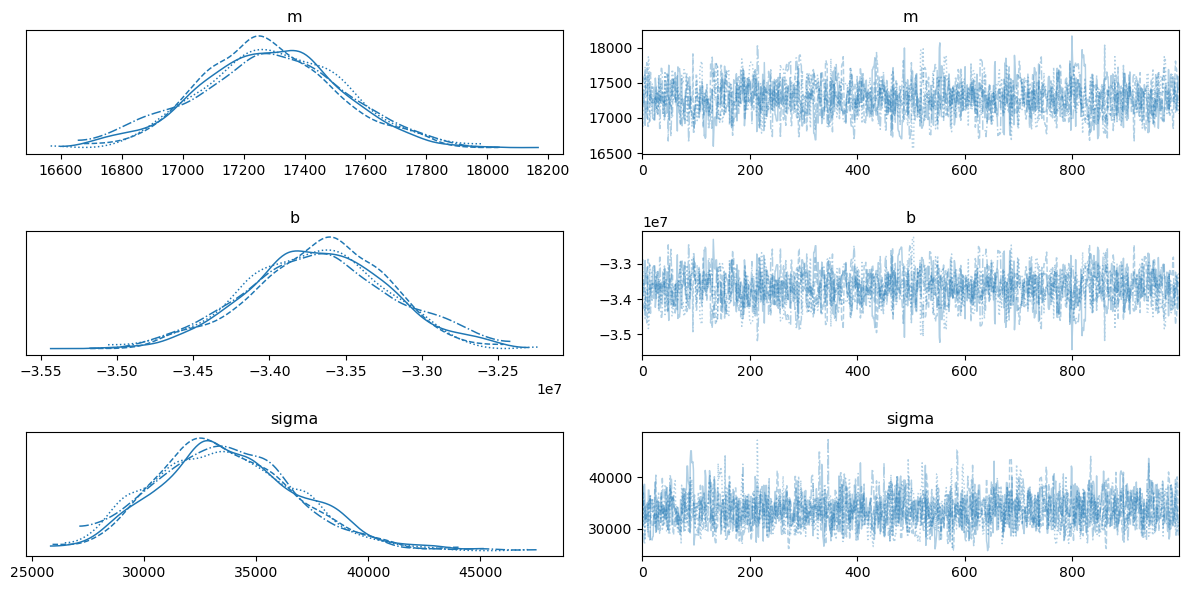

In [12]:
az.plot_trace( fit );
plt.tight_layout()

Exception ignored in: <function tqdm.__del__ at 0x7fe0014a0040>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 160, in display
    d = self.format_dict
        ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1476, in format_dict
    'colour': self.colour}
              ^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 204, in colour
    return self.container.children[-2].style.bar_color
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FloatProgress' object has no attribute 'style'


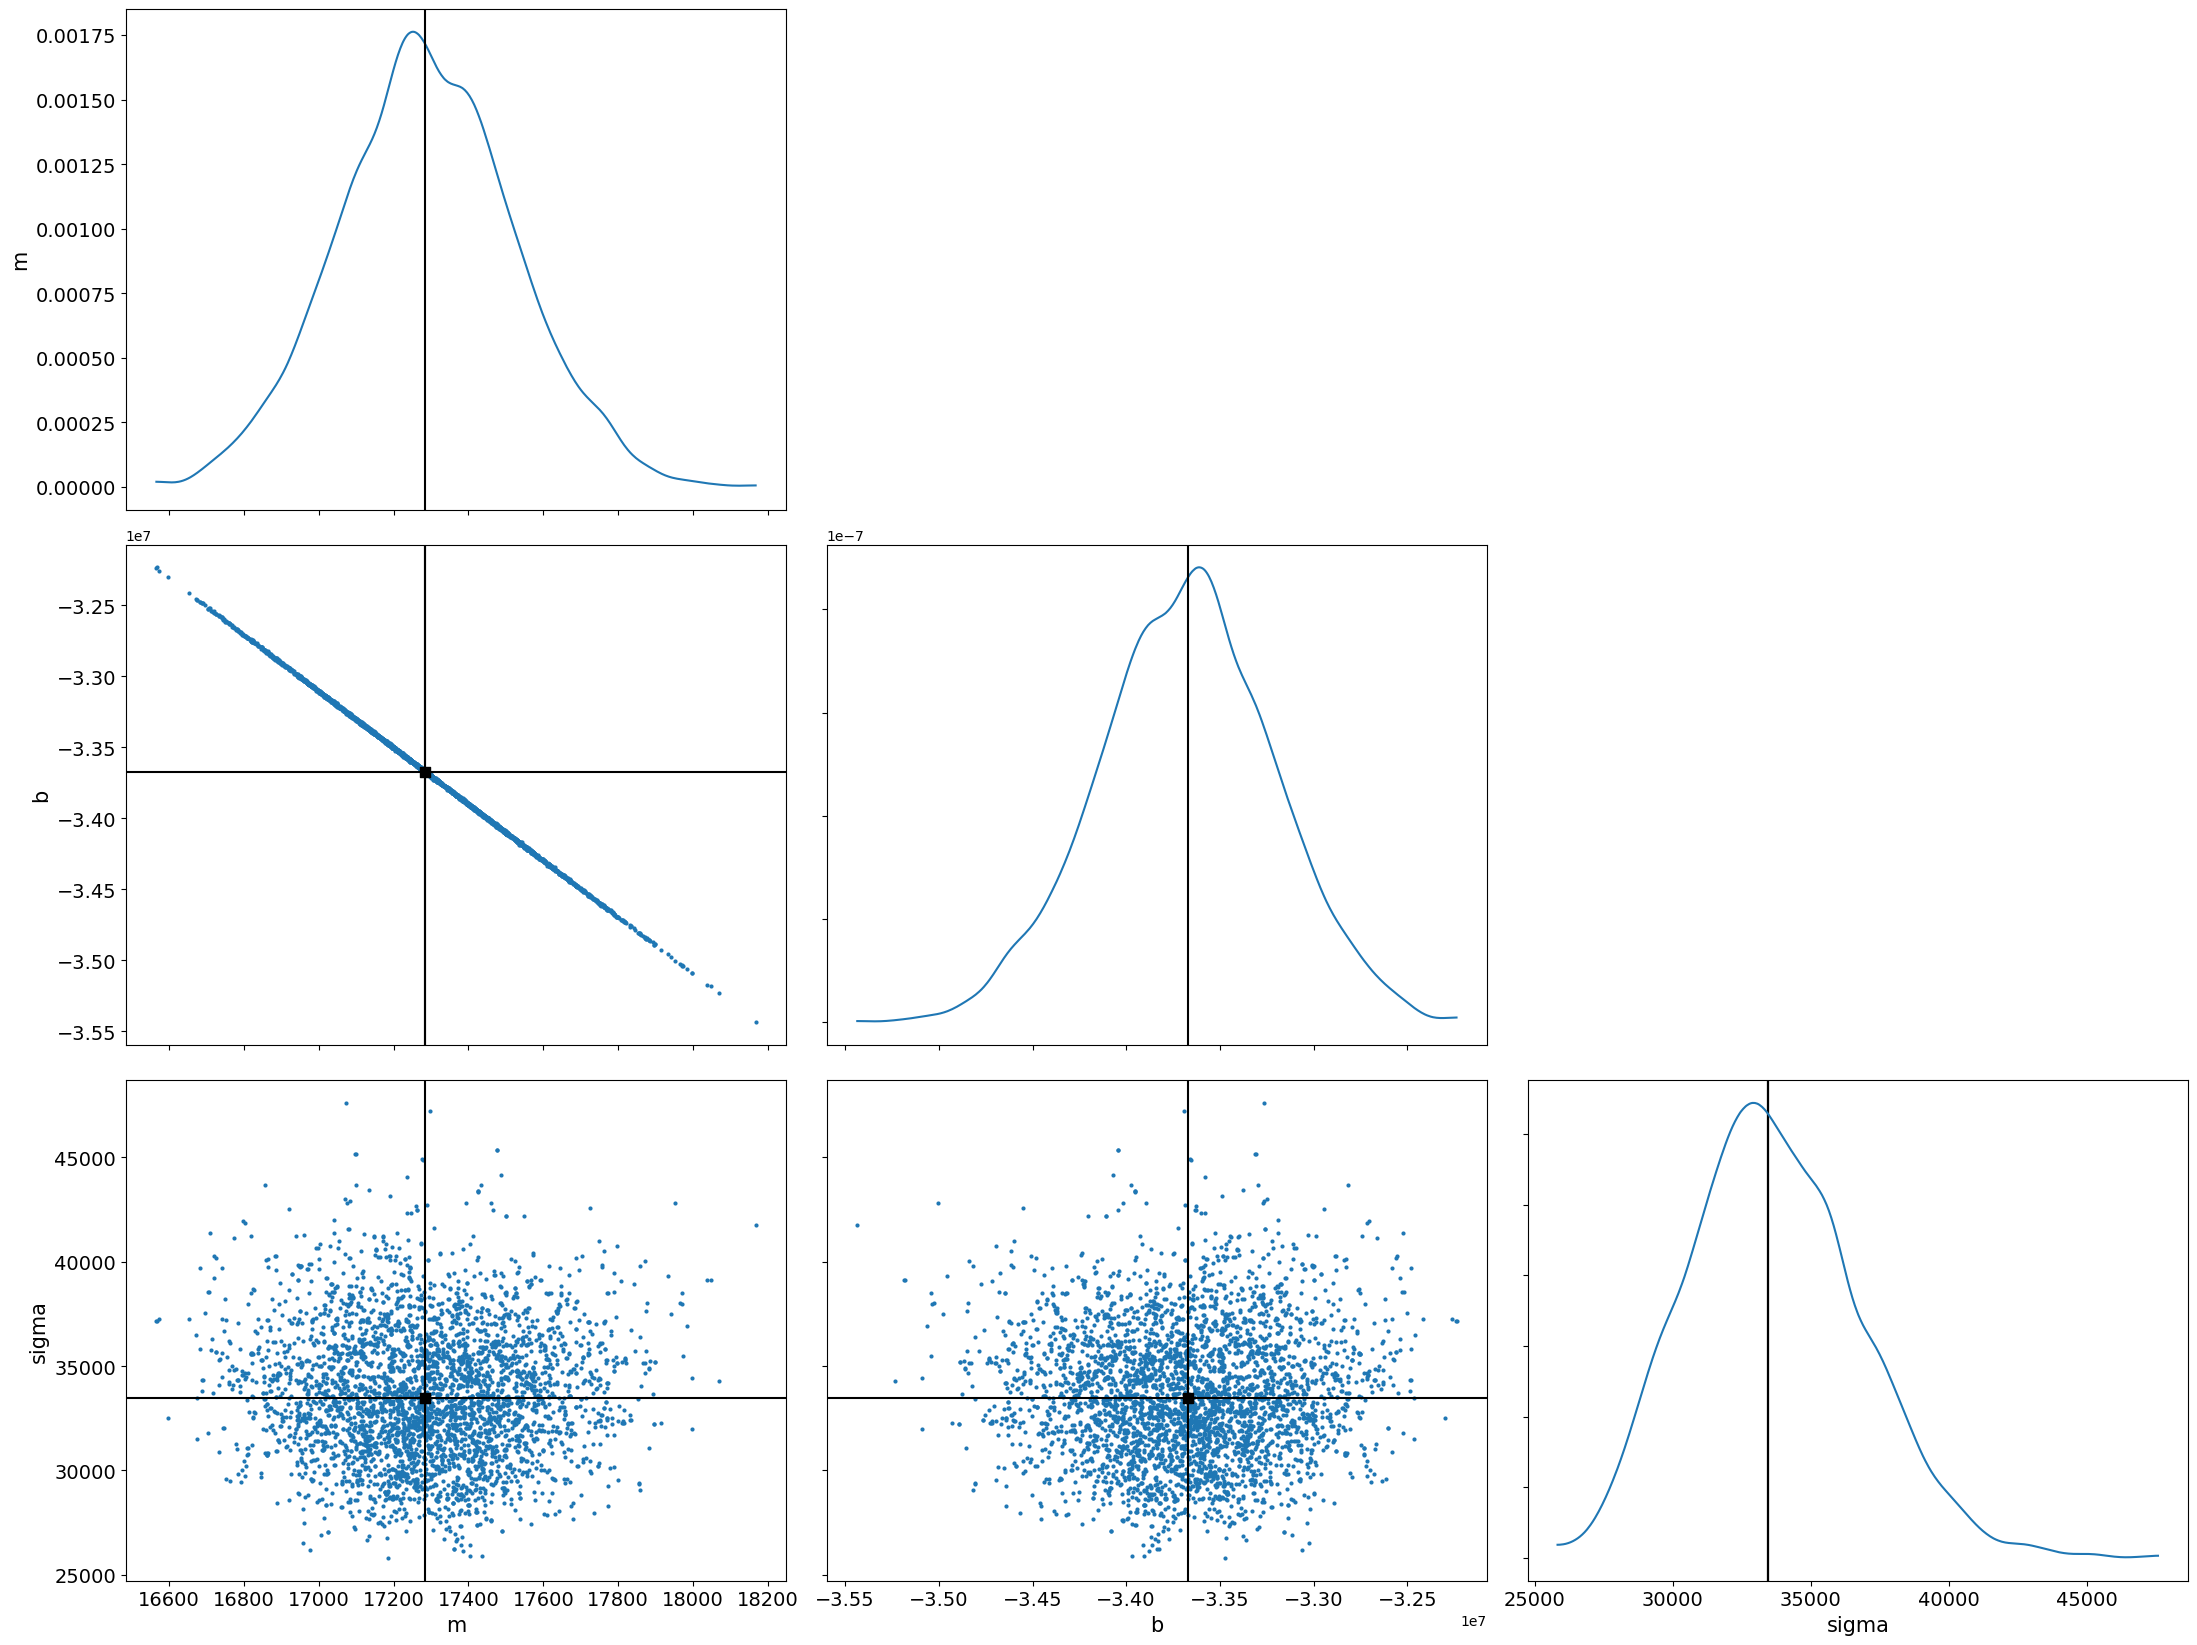

In [15]:
az.plot_pair( fit, marginals=True, point_estimate="median" );
plt.tight_layout()

# Results

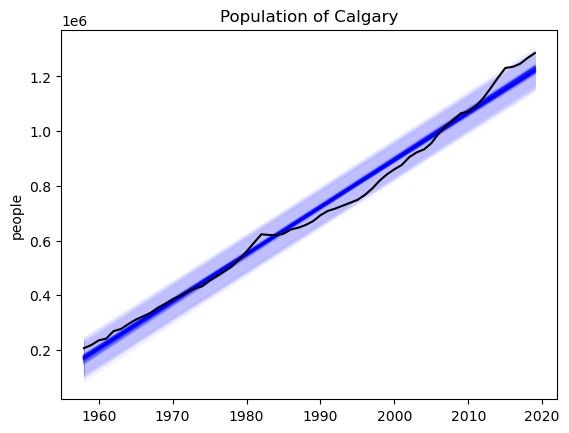

In [14]:
X = np.array( [min(data['X']), max(data['X'])] )

for idx in rng.choice( len(fit.stan_variable('m')), size=64 ):
  model = fit.stan_variable('m')[idx]*X + fit.stan_variable('b')[idx]
  plt.plot( X, model, '-b', alpha=.1 )
  plt.fill_between( X, model - 1.96*fit.stan_variable('sigma')[idx], model + 1.96*fit.stan_variable('sigma')[idx], color='blue', alpha=.005 )

plt.plot( data['X'], data['Y'], '-k', label='data')
plt.title("Population of Calgary")
plt.ylabel('people')
plt.show()